###  Analyzing the Mechanisms of Political Decision-Making in the Formation of Defense Alliances via International Military Deployments: *A Case of NATO*

#### Minimum NATO entry requirements
 - New members must uphold democracy, including tolerating diversity.

 - New members must be making progress toward a market economy.

 - Their military forces must be under firm civilian control.

 - They must be good neighbors and respect sovereignty outside their borders.

 - They must be working toward compatibility with NATO forces.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 14
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import polars as pl
#to use R in Jupyter
%load_ext rpy2.ipython

For faster uploading and data manipulation I will use polars instead of pandas.

In [2]:
%%time
balance = pl.read_csv('https://raw.githubusercontent.com/EmilStasevski/Military-Deployment/main/IMDT.csv',ignore_errors = True)
original_length = balance.shape[0]
original_length = balance.shape[0]
balance = balance.with_columns(
    balance.select(pl.concat_str(['year', 'ccode1'], separator = "_").alias('year_ccode1'))
)
balance = balance.with_columns(
    balance.select(pl.concat_str(['year', 'ccode2'], separator = "_").alias('year_ccode2'))
)
balance = balance.with_columns(
    balance.select(pl.concat_str(['year', 'ccode1', 'ccode2'], separator = "_").alias('dyad'))
)
    
corwar = pl.read_csv('https://raw.githubusercontent.com/EmilStasevski/Military-Deployment/main/Correlates_of_war.csv',ignore_errors = True)

corwar = corwar.with_columns(
    corwar.select(pl.concat_str(['year', 'ccode1'], separator = "_").alias('year_ccode1'))
)
balance = balance.join(corwar[['military_personnel', 'military_expenditures_USDC', 'year_ccode1']], on ='year_ccode1', how = 'left')

vdem = pl.read_csv(r"C:\Users\79534\Documents\Final Theses\data\vdem\VDEM_2023_13_version.csv", ignore_errors = True)

vdem = vdem.with_columns(
    vdem.select(pl.concat_str(['year', 'COWcode'], separator = "_").alias('year_ccode1'))
)
vdem = vdem.with_columns(
    vdem.select(pl.concat_str(['year', 'COWcode'], separator = "_").alias('year_ccode2'))
)
regimes_dict_binary = {
    '0': 'autocracy',
    '1': 'autocracy',
    '2':'autocracy',
    '3':'democracy',
    '4': 'democracy'
}
regimes_dict = {
    '1': 'Closed autocracy',
    '2':'Electoral autocracy',
    '3':'Electoral democracy',
    '4': 'Liberal democracy'
}
vdem  = vdem.with_columns(
    pl.col("v2x_regime").map_dict(regimes_dict).alias("political_regime")
)

vdem  = vdem.with_columns(
    pl.col("v2x_regime").map_dict(regimes_dict_binary).alias("political_regime_binary")
)

vdem = vdem.with_columns(
    pl.col("political_regime").alias("deployer_regime"),
    pl.col('political_regime_binary').alias('deployer_regime_binary'),
    pl.col('political_regime').alias('host_regime'),
    pl.col("political_regime_binary").alias('host_regime_binary'),
)
balance = balance.join(vdem[['year_ccode1', 'deployer_regime','deployer_regime_binary']], on = 'year_ccode1', how = 'left')


balance = balance.join(vdem[['year_ccode2', 'host_regime','host_regime_binary']] , on= 'year_ccode2', how='left')
merged_length = balance.shape[0]
#check duplicates
assert original_length == merged_length
balance = balance.to_pandas()

Wall time: 14.7 s


In [3]:
balance['deployer_NATO'] = 'not NATO member'
balance['host_NATO'] = 'not NATO member'
before_1960 = [20,211,  390, 220, 395, 325, 212, 
          210, 385, 235, 200, 2, 260, 350]
after_2003 = [368, 367, 366, 355, 360, 317, 349]
nato_deployer = (
    (balance.ccode1.isin(before_1960) ) |
    
    ((balance.year > 1982) & (balance.ccode1 == 230)) |
    ((balance.year > 1991) & (balance.ccode1 == 255 )) |
    ((balance.year > 1998) & (balance.ccode1.isin([290, 310, 316])       )) |
    ((balance.year > 2003) & (balance.ccode1.isin(after_2003))) |
    ((balance.year > 2008) & (balance.ccode1.isin([344, 339])     )) |
    ((balance.year > 2016) & (balance.ccode1==341  )) |
    ((balance.year > 2019) & (balance.ccode1== 343)) |
    ((balance.year > 2022) & (balance.ccode1 == 375))  
)

nato_host = (
  (balance.ccode2.isin(before_1960) ) |
    ((balance.year > 1982) & (balance.ccode2 == 230)) |
    ((balance.year > 1991) & (balance.ccode2 == 255 )) |
    ((balance.year > 1998) & (balance.ccode2.isin([290, 310, 316])       )) |
    ((balance.year > 2003) & (balance.ccode2.isin(after_2003))) |
    ((balance.year > 2008) & (balance.ccode2.isin([344, 339])     )) |
    ((balance.year > 2016) & (balance.ccode2==341  )) |
    ((balance.year > 2019) & (balance.ccode2== 343)) |
    ((balance.year > 2022) & (balance.ccode2 == 375))  
)
balance.loc[nato_deployer, 'deployer_NATO'] = 'member of NATO'
balance.loc[nato_host, 'host_NATO'] = 'member of NATO'

balance['period'] = 'unknown'
balance.loc[balance.year < 1993, 'period'] = '1985-1992'
balance.loc[(balance.year > 1992) & (balance.year < 2001 ), 'period'] = '1993-2000'
balance.loc[(balance.year > 2000) & (balance.year < 2014), 'period'] = '2001-2013'
balance.loc[balance.year >2013 , 'period'] = '2014-2022'

assert balance[balance.period == '2020-2022'].shape[0] == 0

balance['five_year'] = '2021-2022'
balance.loc[balance.year < 1991, 'five_year'] = '1985-1990'
balance.loc[(balance.year > 1990) & (balance.year < 1996 ), 'five_year'] = '1991-1995'
balance.loc[(balance.year > 1995) & (balance.year < 2001), 'five_year'] = '1996-2000'
balance.loc[(balance.year > 2000) & (balance.year <2006 ), 'five_year'] = '2001-2005'
balance.loc[(balance.year > 2005) & (balance.year <2011 ), 'five_year'] = '2006-2010'
balance.loc[(balance.year > 2010) & (balance.year < 2016), 'five_year'] = '2011-2015'
balance.loc[(balance.year > 2015) & (balance.year < 2021), 'five_year'] = '2016-2020'

assert balance[(balance.five_year == 'unknown') & (balance.year <2021)].shape[0] == 0

## Descriptive statistics

In [5]:
balance.groupby(['period', 'deployer_NATO'])['Troops'].describe()

count          mean           std  min    25%  \
period    deployer_NATO                                                     
1985-1992 member of NATO    463.0  10104.632829  32016.136533  1.0  105.0   
          not NATO member   827.0   6595.413543  30714.612018  1.0   15.0   
1993-2000 member of NATO   1094.0   2298.570384   8853.691627  1.0    9.0   
          not NATO member  1950.0    676.169231   3251.727537  1.0    5.0   
2001-2013 member of NATO   3181.0   1563.008488   9344.478966  1.0    5.0   
          not NATO member  5143.0    385.231771   2044.163206  1.0    3.0   
2014-2022 member of NATO   2376.0    804.058502   4217.802402  1.0    4.0   
          not NATO member  3762.0    564.735779   4183.788655  1.0    3.0   

                              50%     75%       max  
period    deployer_NATO                              
1985-1992 member of NATO   1100.0  4624.5  245800.0  
          not NATO member   200.0   800.0  380000.0  
1993-2000 member of NATO    150.0  1000.0  123400.0  
          not NATO member    14.0   204.0   36000.0  
2001-2013 member of NATO     42.0   363.0  192600.0  
          not NATO member     9.0   183.5   43000.0  
2014-2022 member of NATO     31.5   218.0   55600.0  
          not NATO member    10.0   215.0  175000.0

In [6]:
balance[balance.five_year !='2021-2022'].groupby(['five_year', 'deployer_NATO'])['Troops'].describe()

count          mean           std  min    25%  \
five_year deployer_NATO                                                     
1985-1990 member of NATO    286.0  12411.979021  36538.018997  1.0  263.0   
          not NATO member   509.0   8465.508841  34746.223706  1.0   58.0   
1991-1995 member of NATO    561.0   3815.916221  15602.960229  1.0   15.0   
          not NATO member  1088.0   1589.862132  12604.714154  1.0    7.0   
1996-2000 member of NATO    710.0   2116.233803   7517.945637  1.0    7.0   
          not NATO member  1180.0    622.222881   3056.958702  1.0    5.0   
2001-2005 member of NATO   1117.0   1823.674127   9751.455089  1.0    6.0   
          not NATO member  1738.0    387.596663   2007.969575  1.0    4.0   
2006-2010 member of NATO   1458.0   1465.875171   9925.875515  1.0    4.0   
          not NATO member  2241.0    346.597947   1917.064394  1.0    3.0   
2011-2015 member of NATO   1148.0   1122.015679   5876.474176  1.0    3.0   
          not NATO member  2092.0    449.529159   2358.884770  1.0    3.0   
2016-2020 member of NATO   1288.0    703.540373   3766.503713  1.0    4.0   
          not NATO member  2076.0    517.327071   2766.497096  1.0    3.0   

                              50%      75%       max  
five_year deployer_NATO                               
1985-1990 member of NATO   1450.0  5500.00  245800.0  
          not NATO member   411.0  1000.00  380000.0  
1991-1995 member of NATO    172.0  1222.00  222500.0  
          not NATO member    20.0   405.25  338000.0  
1996-2000 member of NATO    160.0  1001.50   75665.0  
          not NATO member    10.0   160.00   36000.0  
2001-2005 member of NATO     95.0   580.00  166680.0  
          not NATO member    10.0   156.00   36000.0  
2006-2010 member of NATO     30.0   287.00  192600.0  
          not NATO member     9.0   160.00   36000.0  
2011-2015 member of NATO     20.0   252.75   97000.0  
          not NATO member    10.0   219.25   43000.0  
2016-2020 member of NATO     34.0   220.00   55300.0  
          not NATO member    11.0   213.00   50000.0

In [7]:
balance.groupby(['period', 'deployer_regime_binary'])['Troops'].describe()

count         mean           std  min  \
period    deployer_regime_binary                                           
1985-1992 autocracy                606.0  8937.768977  35600.653860  1.0   
          democracy                679.0  6944.129602  26831.651830  1.0   
1993-2000 autocracy               1289.0   973.089992   3964.560566  1.0   
          democracy               1753.0  1471.079293   7075.066917  1.0   
2001-2013 autocracy               4052.0   447.459033   2293.507719  1.0   
          democracy               4260.0  1206.543427   8099.150233  1.0   
2014-2022 autocracy               3601.0   581.545959   4275.114242  1.0   
          democracy               2520.0   770.039286   4098.422660  1.0   

                                   25%    50%      75%       max  
period    deployer_regime_binary                                  
1985-1992 autocracy               20.0  477.0  1195.00  380000.0  
          democracy               20.0  409.0  2250.00  245800.0  
1993-2000 autocracy                6.0   20.0   412.00   36000.0  
          democracy                6.0   36.0   500.00  123400.0  
2001-2013 autocracy                3.0   10.0   189.25   43000.0  
          democracy                4.0   28.0   313.00  192600.0  
2014-2022 autocracy                3.0   10.0   207.00  175000.0  
          democracy                4.0   26.0   235.00   55600.0

In [8]:
balance[balance.five_year !='2021-2022'].groupby(['five_year', 'deployer_regime_binary'])['Troops'].describe()

count          mean           std  min  \
five_year deployer_regime_binary                                            
1985-1990 autocracy                382.0  11205.450262  39743.401903  1.0   
          democracy                408.0   8766.637255  31082.146681  1.0   
1991-1995 autocracy                746.0   2267.891421  15176.504434  1.0   
          democracy                901.0   2417.981132  12438.993971  1.0   
1996-2000 autocracy                767.0    910.393742   3758.556873  1.0   
          democracy               1123.0   1369.970614   6056.931818  1.0   
2001-2005 autocracy               1253.0    487.284118   2350.890429  1.0   
          democracy               1602.0   1310.936330   8180.156567  1.0   
2006-2010 autocracy               1818.0    385.353685   2120.055675  1.0   
          democracy               1875.0   1180.436267   8769.948001  1.0   
2011-2015 autocracy               1787.0    502.363179   2546.591225  1.0   
          democracy               1443.0    922.089397   5257.052020  1.0   
2016-2020 autocracy               1983.0    532.530005   2829.027213  1.0   
          democracy               1371.0    673.912473   3653.264739  1.0   

                                    25%    50%     75%       max  
five_year deployer_regime_binary                                  
1985-1990 autocracy               125.0  500.0  2375.0  380000.0  
          democracy                58.0  573.5  3100.0  245800.0  
1991-1995 autocracy                 7.0   25.0   506.0  338000.0  
          democracy                 7.0   40.0   576.0  222500.0  
1996-2000 autocracy                 5.0   11.0   339.0   36000.0  
          democracy                 5.0   39.0   500.5   75665.0  
2001-2005 autocracy                 5.0   11.0   197.0   36000.0  
          democracy                 5.0   40.0   372.5  166680.0  
2006-2010 autocracy                 3.0    9.0   150.0   36000.0  
          democracy                 4.0   26.0   265.0  192600.0  
2011-2015 autocracy                 3.0   10.0   220.0   43000.0  
          democracy                 3.0   17.0   240.5   97000.0  
2016-2020 autocracy                 2.0   11.0   207.0   50000.0  
          democracy                 4.0   27.0   235.0   55300.0

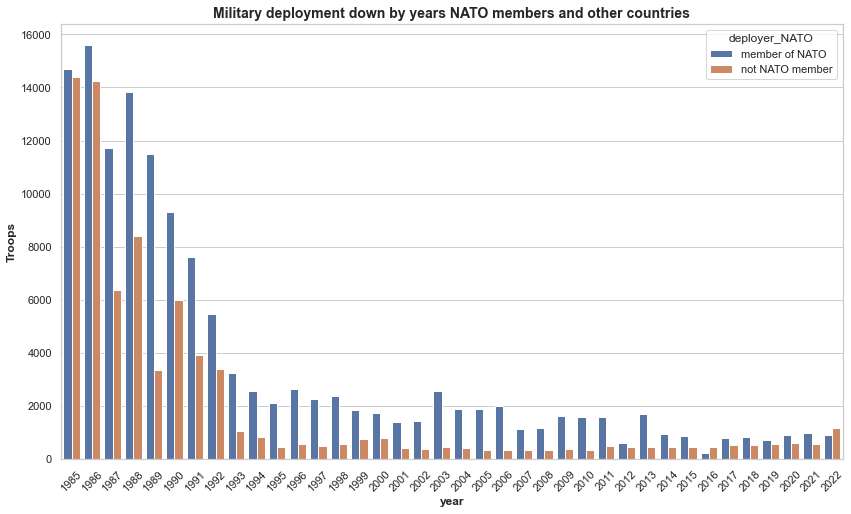

In [254]:
nato_deployment = balance.groupby(['year', 'deployer_NATO'], as_index = False)['Troops'].mean()
fig, ax = plt.subplots( figsize=(14, 8));
ax.set_title("Military deployment down by years NATO members and other countries", fontsize=14,fontweight="bold")
plt.xticks(rotation=45)
plt.xlabel('Year',  fontsize=12, fontweight="bold")
plt.ylabel('Mean number of \ndeployed military personnel',  fontsize=12, fontweight="bold")
sns.barplot(data = nato_deployment, x='year', y='Troops', hue = 'deployer_NATO', ax =ax);

### Nets

In [229]:
balance_networks= balance.rename(columns = {'cowc1':'source', 'cowc2':'target', 'Troops':'weight'})
balance_networks.loc[(balance.ccode1 == 356) & (balance.year < 1992), 'source'] = 'USSR'
balance_networks['weight'] = balance_networks['weight'].fillna(1)
balance_networks['weight'] = np.log1p(balance_networks['weight'] )
networks = []
for i in range(1985, 2023):
    edges = balance_networks[balance_networks.year == i][['source', 'target', 'weight']]
    X = balance_networks[balance_networks.year == i]
    nodes = pd.DataFrame(np.concatenate([ X[['source', 'deployer_regime_binary', 'deployer_NATO']],
                                         X[['target', 'host_regime_binary', 'host_NATO']] ], axis=0), columns= ['node', 'regime', 'NATO'])\
    .drop_duplicates()
    
    g = nx.from_pandas_edgelist(edges, edge_attr='weight')
    nodes_attr =nodes.set_index('node').to_dict(orient = 'index')
    nx.set_node_attributes(g, nodes_attr)
    networks.append(g)

In [230]:
def draw_network_attribute_binary(network, attribute_name,attribute_class_0,
                                  attribute_class_0_color, attribute_class_1,
                                  attribute_class_1_color,  title,    node_size_increase= 25 , random_layout = False):
    degrees = [val*node_size_increase for (node, val) in network.degree()]
    labels = {}
    for (n ,d) in network.degree():
        if d > np.quantile([d for n,d in network.degree()], 0.95  ):
            labels[n]=n
        else:
            labels[n] = ''
    edges = network.edges()
    weights = [network[u][v]['weight'] for u,v in edges]
    
    color_attribute = []
    for node, attribute in nx.get_node_attributes(network,attribute_name ).items():
        if attribute == attribute_class_0:
            color_attribute.append(attribute_class_0_color)
        else:
            color_attribute.append(attribute_class_1_color)
    plt.figure(figsize=(12, 6))
    
    if random_layout:
        nx.draw(network, labels = labels, pos=nx.random_layout(network),edge_color='#98c1d9',
                node_color = color_attribute, node_size=degrees, with_labels =True)
    else:
        nx.draw(network, labels = labels,   node_color = color_attribute,edge_color='#98c1d9',
                node_size=degrees, with_labels =True)
    
        
    
    plt.title(title, fontweight='bold', fontsize=14)
   
    

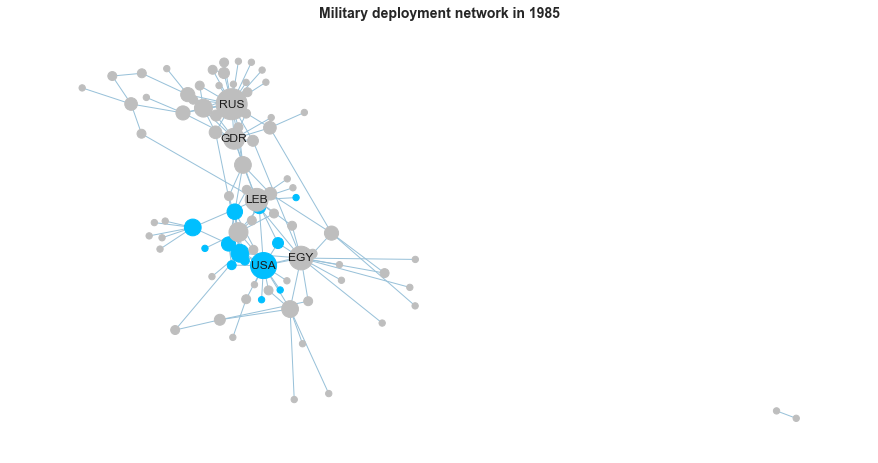

In [240]:
draw_network_attribute_binary(networks[0], 'NATO', 'member of NATO', '#00BFFF',
                              'not NATO member', '#BEBEBE', 'Military deployment network in 1985',  40)

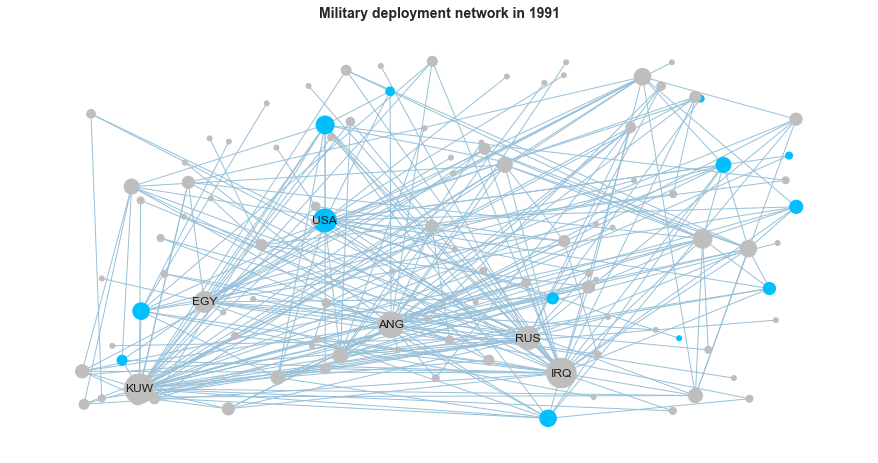

In [241]:
draw_network_attribute_binary(networks[6], 'NATO', 'member of NATO', '#00BFFF',
                              'not NATO member', '#BEBEBE', 'Military deployment network in 1991', random_layout= True)

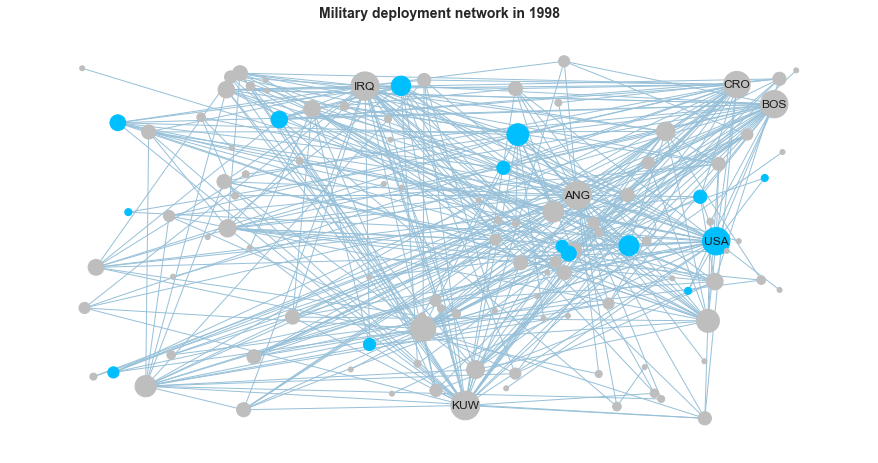

In [242]:
draw_network_attribute_binary(networks[13], 'NATO', 'member of NATO', '#00BFFF',
                              'not NATO member', '#BEBEBE', 'Military deployment network in 1998', random_layout = True)

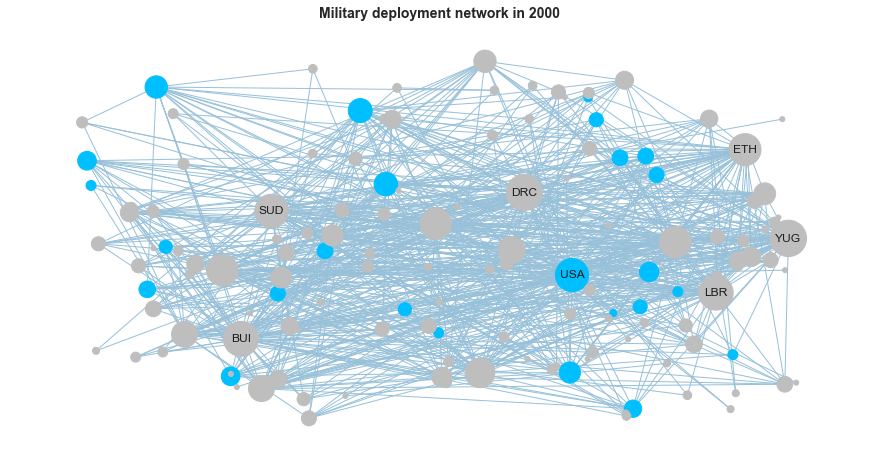

In [245]:
draw_network_attribute_binary(networks[20], 'NATO', 'member of NATO', '#00BFFF',
                              'not NATO member', '#BEBEBE', 'Military deployment network in 2000', random_layout = True)

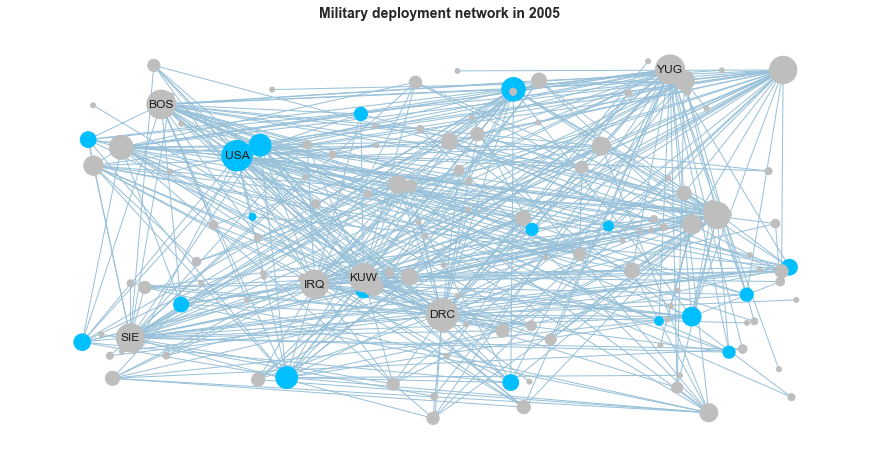

In [246]:
draw_network_attribute_binary(networks[15], 'NATO', 'member of NATO', '#00BFFF',
                              'not NATO member', '#BEBEBE', 'Military deployment network in 2005', random_layout = True)

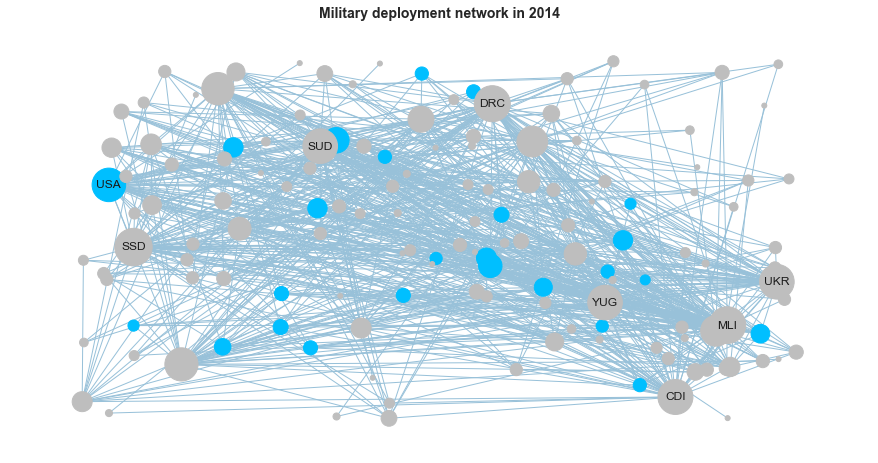

In [247]:
draw_network_attribute_binary(networks[29], 'NATO', 'member of NATO', '#00BFFF',
                              'not NATO member', '#BEBEBE', 'Military deployment network in 2014', random_layout = True)

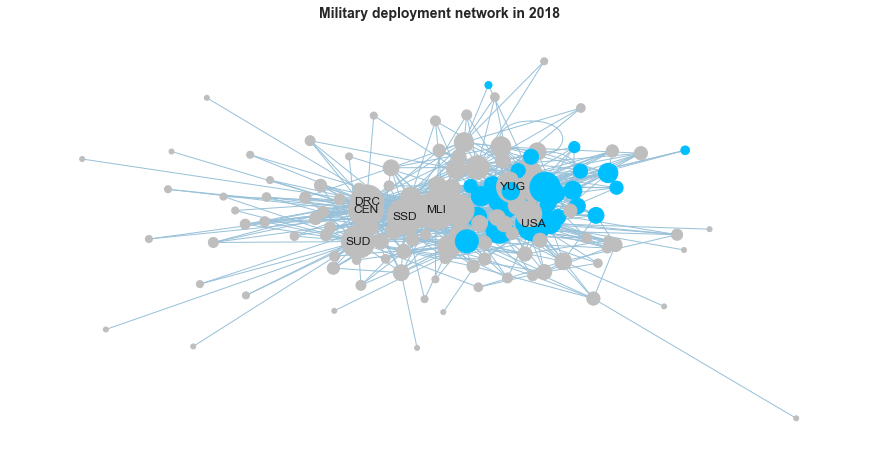

In [248]:
draw_network_attribute_binary(networks[33], 'NATO', 'member of NATO', '#00BFFF',
                              'not NATO member', '#BEBEBE', 'Military deployment network in 2018')

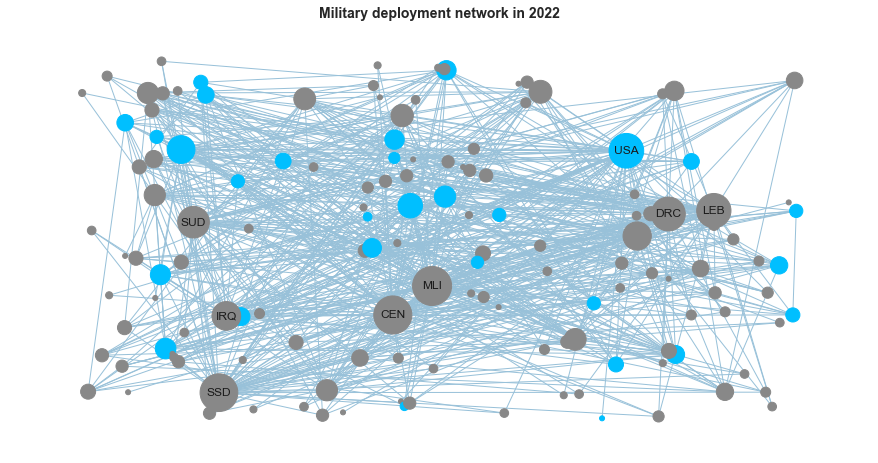

In [251]:
draw_network_attribute_binary(networks[-1], 'NATO', 'member of NATO', '#00BFFF',
                              'not NATO member', '#888888', 'Military deployment network in 2022', random_layout = True )

### Stochastic Actor Oriented Models

In [86]:
%%R
library(RSienaTest)